In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path
import scipy.stats
import time

from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, fitGMM
from open_spiel.python.examples.ubc_utils import *
import open_spiel.python.examples.ubc_dispatch as dispatch

from auctions.webutils import *

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"


from open_spiel.python.examples.ubc_cma import *

output_notebook()
from open_spiel.python.games.clock_auction_base import InformationPolicy, ActivityPolicy, UndersellPolicy, TiebreakingPolicy
from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_decorators import TakeSingleActionDecorator, TremblingAgentDecorator, ModalAgentDecorator

Loading BokehJS ...

In [2]:
# load runs from experiments
experiments = []
experiments += ['contrast']
runs = []
for experiment in experiments:
    runs += Experiment.objects.get(name=experiment).equilibriumsolverrun_set.all()
print(f"Found {len(runs)} runs")

Found 120 runs


# Analyze runs

In [4]:
# empirical = True
# USE_MODAL = True

records = []
for run in tqdm(runs):
    try:
    
        try:
            game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=True, load_policy=False)
        except Exception as e:
            print(f"Skipping run {run.name} because of error {e}")
            continue

#         if USE_MODAL:
#             evaluation = final_checkpoint.get_modal_eval()
#             # if make_combo_specific(evaluation):
#             #     print(run.name)
#         else:
#             evaluation = final_checkpoint.get_old_eval()
            
            
        # total_entropy = analyze_samples(final_checkpoint.get_old_eval().samples, game)['total_entropy'] # Use old eval since modal is stupid for this and it's a convergence test

        # if empirical: 
        #     history_dists = empirical_history_distribution(final_checkpoint.get_old_eval()) # Always use the old eval here
        #     history_entropies = [scipy.stats.entropy(list(history_dists.loc[type_combo].values)) for type_combo in np.unique(history_dists.index.get_level_values(0))]
        # else:
        #     history_dists = compute_per_type_combo(history_distribution, policy, game, min_prob=0.01, history_type='processed')
        #     history_entropies = [scipy.stats.entropy(list(history_dists[type_combo].values())) for type_combo in history_dists]

        # try:
        #     # TODO: Broken until you remove "Tremble" agents
        #     _, _, approx_nash_conv = find_best_checkpoint(run)
        # except:
        #     # TODO: Fix bug where this actually happens because your BRs failed to do better and you have an Empirical Nash Conv of 0, very different from NaN
        #     # ev_df = parse_run(run, None)
        #     # display(ev_df)
        #     approx_nash_conv = np.nan

        record = {
            # clock auction params
            'game_name': run.game.name, 
            'potential': run.config.get('potential_function', 'None'),
            'seed': run.config.get('seed'), 
            'run_name': run.name,
            'experiment': run.experiment.name,
            'config': run.get_config_name(),
            't': final_checkpoint.t,

            # CMA knobs
            'information_policy': InformationPolicy(game.auction_params.information_policy).name,
            'activity_policy': ActivityPolicy(game.auction_params.activity_policy).name,
            'undersell_policy': UndersellPolicy(game.auction_params.undersell_policy).name,
            'tiebreaking_policy': TiebreakingPolicy(game.auction_params.tiebreaking_policy).name,
            'grace_rounds': game.auction_params.grace_rounds,
            'risk_aversion': 'risk' in run.game.name, # TODO: actually read this from players
            'spite': 'spite' in run.game.name, # TODO: actually read this from players
            'clock_speed': game.auction_params.increment,
            'base_game_name': '_'.join(run.game.name.split('/')[1].split('_')[:2]), # Stupid naming convention that will surely bite us later

            # solver information
            'alg': get_algorithm_from_run(run),
            'walltime': run.walltime(),

            # metrics from eval
            # 'total_entropy': total_entropy,

            # stats about history distribution
            # 'avg_distinct_histories': np.mean([len(d) for d in history_dists.values()]),
            # 'avg_history_entropy': np.mean(history_entropies),
        } 
        
        evaluation = final_checkpoint.get_modal_eval()
        # evaluation = final_checkpoint.get_old_eval()
        
        record['nash_conv'] = evaluation.nash_conv
        record['rewards'] = evaluation.mean_rewards
        record['nash_conv_frac'] = evaluation.nash_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.nash_conv) else np.nan
        record['heuristic_conv'] = evaluation.heuristic_conv
        record['heuristic_conv_frac'] = evaluation.heuristic_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.heuristic_conv) else np.nan
        
        for i in range(game.num_players()):
            record[f'rewards_{i}'] = evaluation.mean_rewards[i]
            record[f'nc_player_improvements_{i}'] = evaluation.nash_conv_player_improvements[i] if not pd.isnull(evaluation.nash_conv) else np.nan
            record[f'nc_player_improvements_frac_{i}'] = (evaluation.nash_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.nash_conv) else np.nan
        
            record[f'hc_player_improvements_{i}'] = evaluation.heuristic_conv_player_improvements[i] if not pd.isnull(evaluation.heuristic_conv) else np.nan
            record[f'hc_player_improvements_frac_{i}'] = (evaluation.heuristic_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.heuristic_conv) else np.nan
          
        record.update(**analyze_samples(evaluation.samples, game))

        # Slowwwwww you may want to comment this out when not using it
#         start = time.time()
        # c = final_checkpoint.equilibrium_solver_run.config
        # env_and_policy = ppo_db_checkpoint_loader(final_checkpoint)
        # for player in range(game.num_players()):
        #     env_and_policy.agents[player] = ModalAgentDecorator(env_and_policy.agents[player])
        # modal_policy = env_and_policy.make_policy()
        
        # worked, time_taken, hc = time_bounded_run(15, nash_conv, game, modal_policy, restrict_to_heuristics=True)
        # if not worked:
        #     print("Aborted run because time")
        # record['heuristic_conv'] = hc if worked else np.nan
        # record['heuristic_conv_time'] = time_taken
#         print(time.time() - start)

        records.append(record)
    
        nc = record['nash_conv']
        hc = record['heuristic_conv']
        # print(f"NashConv = {(np.nan if pd.isnull(nc) else nc):.2f}; HeuristicConv = {(np.nan if pd.isnull(hc) else hc):.2f}")
    except Exception as e:
        print(f"Something wrong with {run}. Skipping. {e}")
        # raise e
        # break
        import traceback
        print(traceback.format_exc())

print(len(records))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:24<00:00,  4.91it/s]

120


In [6]:
df = pd.DataFrame.from_records(records)
# df['imperfect'] = df['game_name'].str.contains('imperfect')


In [7]:
df['rule_set'] = df.apply(lambda row: row.game_name.split(row.base_game_name)[1][1:-5], axis=1)

In [8]:
# TODO: Maybe actually make this readable?
df['variant'] = list(map(str,(zip(df.information_policy, df.clock_speed, df.activity_policy, df.undersell_policy, df.tiebreaking_policy, df.risk_aversion, df.grace_rounds))))
palette = dict()

colors = ['red', 'blue', 'magenta', 'green', 'orange', 'brown', 'black', 'navy', 'pink', 'gold', 'darkgreen', 'orangered', 'olive']

for i, v in enumerate(df['variant'].unique()):
    palette[v] = colors[i]

In [9]:
# Need to a) Remove "bad" entries b) Be careful about comparisons that are missing datapoints 
df_plt = df.copy()

In [10]:
### Remove bad entries
good_thresh = 0.1
# good_thresh_abs = 5
# df_plt = df.query(f'player_improvements_0 < {good_thresh_abs} and player_improvements_1 < {good_thresh_abs}')
df_plt = df.query(f'hc_player_improvements_frac_0 < {good_thresh} and hc_player_improvements_frac_1 < {good_thresh}')
# df_plt = df.query(f'nash_conv_frac < {good_thresh}')
len(df), len(df_plt)

# (df.groupby('game_name').size() - df_plt.groupby('game_name').size()).sort_values()

(120, 93)

In [11]:
# df.query('activity_policy == "OFF"')['nash_conv_frac']
# df.query('undersell_policy == "UNDERSELL" and information_policy == "SHOW_DEMAND" and activity_policy == "ON" and clock_speed == 0.3 ')[['t', 'nash_conv', 'nash_conv_frac']]

93


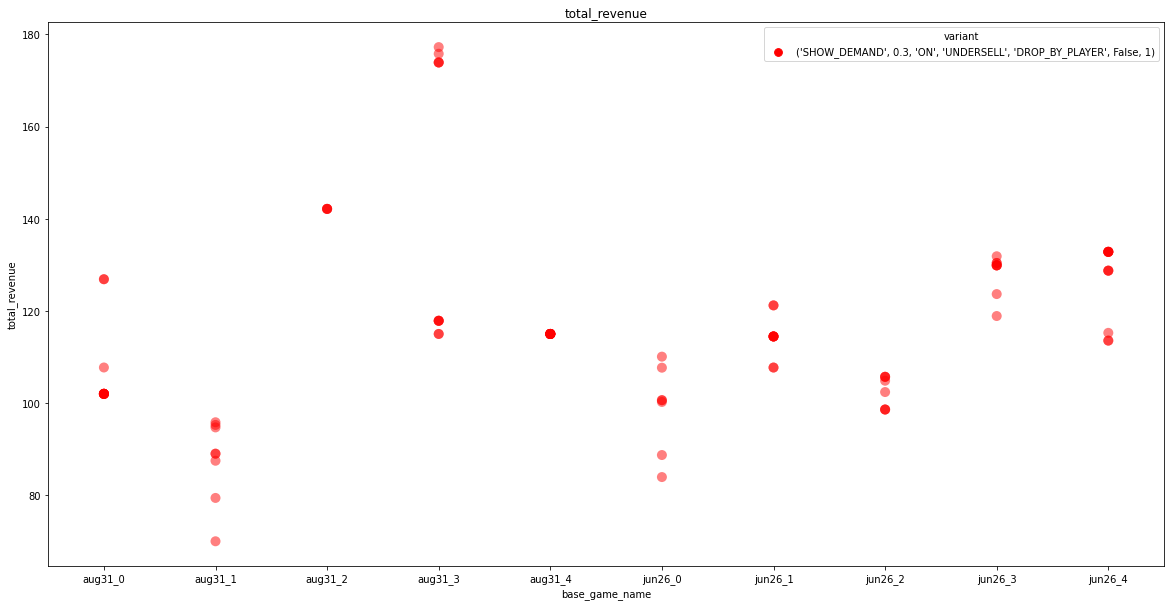

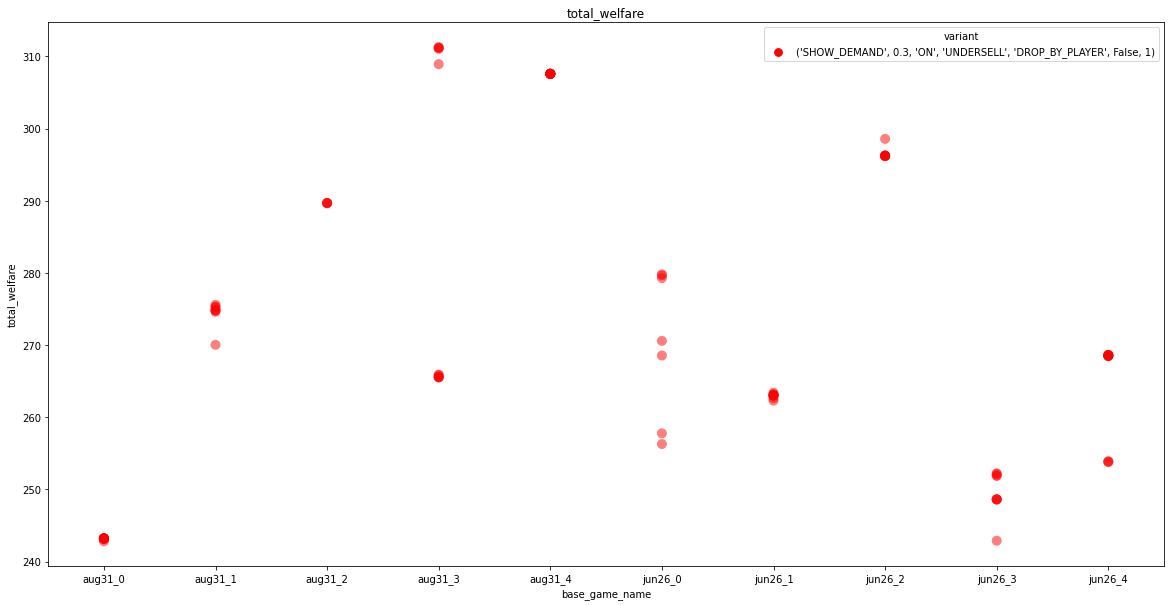

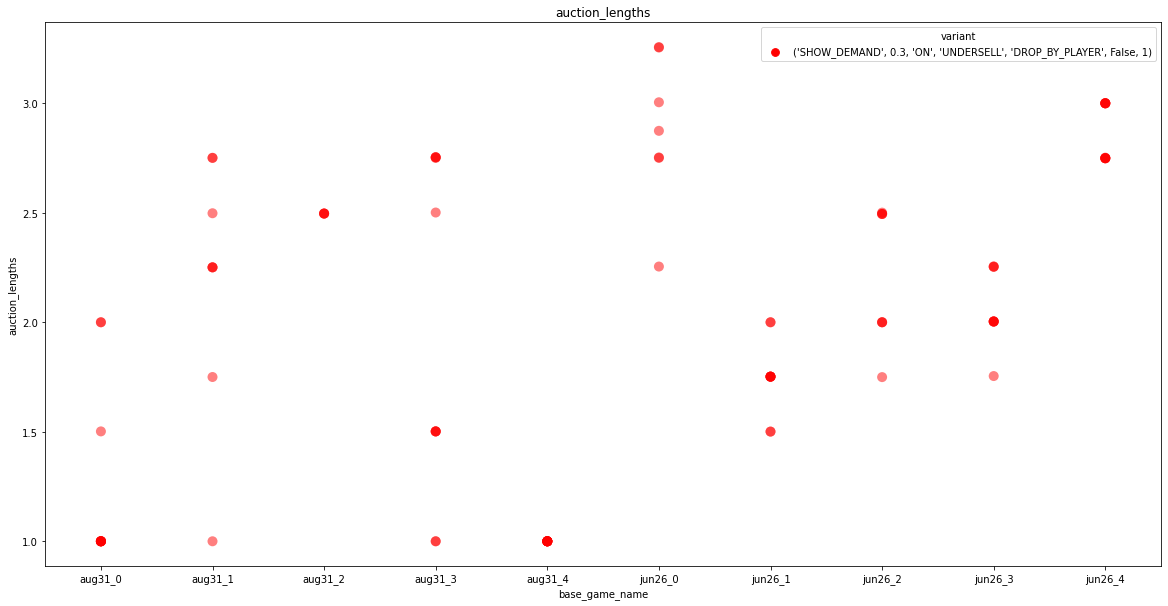

In [12]:
ATTRIBUTE = 'variant'
NORMALIZED = False
plot_type = 'scatter'
box_df = df_plt.copy()
markers = ['o', 'X', '^']

# TODO: These strings are getting unwieldy

# Vanilla for clock
CLOCK_QUERY = 'information_policy == "SHOW_DEMAND" and activity_policy == "ON" and undersell_policy == "UNDERSELL" and grace_rounds == 1 and tiebreaking_policy == "DROP_BY_PLAYER"'
# box_df = box_df.query(CLOCK_QUERY)

# # Check undersell
UNDERSELL_QUERY = 'information_policy == "SHOW_DEMAND" and activity_policy == "ON" and clock_speed == 0.3 and grace_rounds == 1'
# box_df = box_df.query(UNDERSELL_QUERY)

# # Check activity
ACTIVITY_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and grace_rounds == 1'
# box_df = box_df.query(ACACTIVITY_QUERY)

# # Check tiebreaking
TIEBREAKING_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and activity_policy == "ON" and grace_rounds == 1'
# box_df = box_df.query(TIEBREAKING_QUERY)

# Check grace
GRACE_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and activity_policy == "ON" and tiebreaking_policy == "DROP_BY_PLAYER" and not risk_aversion'
# box_df = box_df.query(GRACE_QUERY)

# Activity ON vs grace vs activity OFF
box_df = box_df.query('information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and tiebreaking_policy == "DROP_BY_PLAYER" and not risk_aversion')


box_df = box_df.sort_values(['clock_speed', 'game_name', 'config'])

# box_df = box_df.query('alg.str.contains("outcome")')

print(len(box_df))


STATS = ['total_revenue', 'total_welfare', 'auction_lengths']
# Normalize by the mean of the "base" version, so the scales line up better in the same graph
if NORMALIZED: 
    for stat in STATS:
        base = str(('SHOW_DEMAND', 0.3))
        base_stat = box_df.pivot_table(index=['base_game_name'], values=stat, aggfunc='mean', columns=ATTRIBUTE)
        box_df[f'normalized_{stat}'] = box_df.apply(lambda x: x[stat] / base_stat.loc[x['base_game_name'], base], axis=1)

for stat in STATS:
    if NORMALIZED:
        stat = f'normalized_{stat}'
    plt.figure(figsize=(20,10))
    if plot_type == 'box':
        ax = sns.boxplot(data=box_df, x='base_game_name', y=stat, hue=ATTRIBUTE)
        # ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    else:
        strip_kwargs = dict(x='base_game_name', y=stat, hue=ATTRIBUTE, s=10, alpha=0.5, dodge=True, jitter=False, palette=palette)
        sns.stripplot(data=box_df, **strip_kwargs)
        # for i, config in enumerate(box_df['config'].unique()):
        #     # print(config, markers[i])
        #     # TODO: If no entries exist, this pushes colours to the wrong positions
        #     ax = sns.stripplot(data=box_df.query(f'config == "{config}"'), marker=markers[i], **strip_kwargs)
        #     if i == 0:
        #         old_handles, old_labels = ax.get_legend_handles_labels()
        # ax.legend(old_handles, old_labels)

    plt.title(f"{stat}")

In [18]:
df_plt['rule_set'].value_counts()

def rule_set_to_value_structure(s):
    if 'spite' in s:
        return 'spite'
    elif 'risk_averse' in s:
        return 'risk_averse'
    else:
        return 'quasi_linear'

def rule_set_to_rule(s):
    if s % 2:
        return 'base'
    else:
        return 'also_base'
    
    
df_plt['value_structure'] = df_plt['rule_set'].apply(rule_set_to_value_structure)
df_plt['rule'] = df_plt['seed'].apply(rule_set_to_rule)

/tmp/ipykernel_19709/3546531704.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plt['value_structure'] = df_plt['rule_set'].apply(rule_set_to_value_structure)
/tmp/ipykernel_19709/3546531704.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plt['rule'] = df_plt['seed'].apply(rule_set_to_rule)


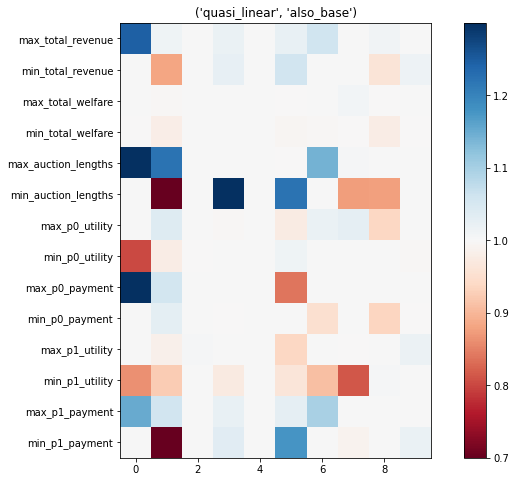

In [19]:
# 1) Get max/min for each valuation/treatment pairing over each stat

# First query down to relevant datapoints. Then groupby rule change and SATS =(game_name) and max/min?
metrics = ['total_revenue', 'total_welfare', 'auction_lengths']
for i in range(2): # TODO:
    metrics += [f'p{i}_utility', f'p{i}_payment']


df_plt_indexed = df_plt.set_index(['value_structure', 'rule']).sort_index().copy()

def make_data_dict(df):
    data = dict()
    for metric in metrics:
        data[f'max_{metric}'] = df.groupby('base_game_name')[metric].max()
        data[f'min_{metric}'] = df.groupby('base_game_name')[metric].min()
    return pd.DataFrame(data)
    
for idx, grp_df in df_plt.groupby(['value_structure', 'rule']):
    if idx[1] == 'base':
        continue
        
    data_grp_df = make_data_dict(grp_df)
    normalizer_grp_df = df_plt_indexed.loc[(idx[0], 'base')]
    data_normalized_df = make_data_dict(normalizer_grp_df)
    
    cmap_norm = plt.matplotlib.colors.TwoSlopeNorm(vmin=0.7, vcenter=1, vmax=1.3)
    cmap = plt.cm.get_cmap('RdBu').copy()
    cmap.set_bad('magenta')
    plt.figure(figsize=(12, 8))
    data = (data_grp_df / data_normalized_df).values.T
    plt.imshow(data, cmap=cmap, norm=cmap_norm)
    plt.title(idx)
    plt.yticks(range(len(data_grp_df.columns)), data_grp_df.columns)
    plt.colorbar()
    plt.show()

    
# for query in [CLOCK_QUERY, UNDERSELL_QUERY, ACTIVITY_QUERY, TIEBREAKING_QUERY, GRACE_QUERY]: 
#     clock_df = df_plt.query(query)
#     data = dict()
#     for metric in metrics:
#         data[f'max_{metric}'] = clock_df.groupby(['rule_set', 'base_game_name'])[metric].max()
#         data[f'min_{metric}'] = clock_df.groupby(['rule_set', 'base_game_name'])[metric].min()

#     heatmap_df = pd.DataFrame(data) 
    


In [ ]:
heatmap_df.reset_index()['rule_set'].unique()

In [ ]:
df.query('run_name.str.contains("jun26_jun26_4_grace_period-cfr_port_2external_plus-100")')['nash_conv']

In [ ]:
df.query('information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3')[['nash_conv_frac']]

In [ ]:


# ### Code to rerun evals for a failed experiment
# from open_spiel.python.examples.ubc_dispatch import dispatch_eval_database
# exp = 'jun5outcome'

# for e in Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name=exp):
#     experiment_name = e.checkpoint.equilibrium_solver_run.experiment.name
#     run_name = e.checkpoint.equilibrium_solver_run.name
#     t = e.checkpoint.t
#     dispatch_eval_database(experiment_name, run_name, t, None, None)
# print(Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name=exp).delete())

In [ ]:
df.query('alg == "PPO"').groupby(['experiment', 'imperfect']).mean()

In [ ]:
# val_df.groupby(['game', 'alg']).describe()
val_df.groupby(['game', 'alg']).describe()

In [ ]:
# import open_spiel.python.examples.ubc_dispatch as dispatch
# for run in runs:
#     try:
#         game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False)
#     except:
#         print("Skipping", run)
#         continue
#     final_checkpoint.bestresponse_set.all().delete()
#     for player in range(game.num_players()):
#         dispatch.dispatch_eval_database(run.experiment.name, run.name, final_checkpoint.t, player, 'modal') 
#         dispatch.dispatch_eval_database(run.experiment.name, run.name, final_checkpoint.t, player, 'tremble')  

In [ ]:
### This is the cell you run when you want to rerun evals 
bad_count = 0
overwrite_existing = True
for run in tqdm(runs):
    # print(run)
    try:
        game, final_checkpoint, policy = get_results(run, load_policy=False)
    except Exception as e:
        print(f"Skipping run {run.name} because of error {e}")
        continue

    try:
        ev = final_checkpoint.get_modal_eval()
        if not pd.isnull(ev.nash_conv) and not overwrite_existing:
            continue
        else:
            ev.delete()
    except Exception as e:
        ev = None

    bad_count += 1
    br_mapping = {p: 'modal' for p in range(2)}
    dispatch.dispatch_eval_database(final_checkpoint.t, run.experiment.name, run.name, str(br_mapping))
    
print(bad_count)

In [107]:
### Reproduce hide demand error

game = pyspiel.load_game('python_clock_auction', dict(filename='aug31/aug31_1_hide_demand.json'))
run = EquilibriumSolverRun.objects.get(name='aug31_aug31_1_hide_demand-cfr_port_2_no_extoutcome_lin_avg_plus-101')
checkpoint = run.equilibriumsolverruncheckpoint_set.last()
env_and_policy = ppo_db_checkpoint_loader(checkpoint)

for i in range(2):
    env_and_policy.agents[i] = ModalAgentDecorator(env_and_policy.agents[i])
print("Starting")
nash_conv(game, env_and_policy.make_policy(), return_only_nash_conv=False, restrict_to_heuristics=True)


Starting
[0, 2]
[0, 2]
[0, 2]


_NashConvReturn(nash_conv=6.089289116705288, player_improvements=array([6.08928912, 0.        ]), br_policies=[<open_spiel.python.algorithms.best_response.BestResponsePolicy object at 0x7f81de3268e0>, <open_spiel.python.algorithms.best_response.BestResponsePolicy object at 0x7f81de326310>])

In [85]:
z[z > 2]

2    3
dtype: int64